# Pygformula pipeline with features identiying L

In [1]:
import numpy as np
import pygformula
from pygformula import ParametricGformula
from pygformula.interventions import static

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
%matplotlib ipympl

# Load MIMIC data

In [5]:
mimicdata = pd.read_parquet('../Dataset/mimic-iv/from_pipeline/ltm_grided_clipped_A_Y_D_SelfPipeline.parquet')

In [6]:
mimicdata.shape

(600080, 38)

In [7]:
mimicdata.columns

Index(['stay_id', 'grid_end', 'vent_mode__hours_since_last__last_12h',
       'temperature__mean__last_12h', 'heart_rate__mean__last_12h',
       'arterial_blood_pressure_mean__mean__last_12h',
       'fluid_out_urine__mean__last_12h', 'pco2_arterial__mean__last_12h',
       'respiratory_rate_measured__mean__last_12h',
       'o2_saturation__mean__last_12h', 'po2_arterial__mean__last_12h',
       'bicarbonate_arterial__last__last_12h',
       'activated_partial_thromboplastin_time__last__last_12h',
       'hemoglobin__last__last_12h', 'creatinine__last__last_12h',
       'ureum__last__last_12h', 'lactate__last__last_12h',
       'glasgow_coma_scale_total__last__last_12h', 'o2_flow__last__last_12h',
       'vent_mode__last__last_12h', 'raw_age', 'sex', 'raw_height',
       'raw_weight', 'unit_type', 'origin', 'los', 'intime', 'outtime',
       'death_time_from_intime', 'icu_mortality', 'death_abs_time',
       'mortality_after_discharge', 't', 'ref_time', 'A', 'D', 'Y'],
      dtype='ob

In [8]:
mimicdata.rename(columns={"stay_id": "admission_id", "t": "t0", "raw_age":"age", "raw_height":"height", "raw_weight":"weight"}, inplace=True)

In [9]:
mimicdata.vent_mode__last__last_12h = mimicdata.vent_mode__last__last_12h.astype("category")

In [10]:
mimicdata.vent_mode__last__last_12h.value_counts()

vent_mode__last__last_12h
unknown                523752
invasive_controlled     56749
invasive_assisted       19533
cancelled                  46
Name: count, dtype: int64

In [11]:
mimicdata.o2_flow__last__last_12h.describe()

count    45391.000000
mean        46.682819
std         13.799693
min          7.342648
25%         40.000000
50%         40.000000
75%         50.000000
max         87.342648
Name: o2_flow__last__last_12h, dtype: float64

var = "vent_mode__hours_since_last__last_12h"
sns.kdeplot(data=mimicdata, x=var, fill=True, bw_adjust=1)
plt.title(var)
plt.tight_layout()
plt.show()

# Declare baseline variables and meta variables

In [12]:
#baseline = ['age',
#            'gender',
#            'ethnicity',
#            'insurance'
#            ]
baseline = ["age", 
            "sex", 
            #"height", 
            #"weight", 
            #"unit_type", 
            "origin"]

In [13]:
# Pacmed - 7.8% have died inside the ICU
mimicdata.groupby('admission_id').tail(1)['D'].mean()

np.float64(0.11393410083366415)

In [14]:
# Pacmed - 3.3% have died outside the ICU within 7 days after discharge
mimicdata.groupby('admission_id').tail(1)['Y'].mean()

np.float64(0.013269555133881509)

In [15]:
# Pacmed - 92% have been discharged from the ICU. The rest died inside the ICU which tallied with 7.8% that have D=1
mimicdata.groupby('admission_id').tail(1)['A'].mean()

np.float64(0.8860658991663358)

In [16]:
picked_L = [
    #'vent_status__last__last_12h',
    'vent_mode__last__last_12h',
    'vent_mode__hours_since_last__last_12h',
    
    'bicarbonate_arterial__last__last_12h',
    'activated_partial_thromboplastin_time__last__last_12h',
    'temperature__mean__last_12h',

    'hemoglobin__last__last_12h',
    'heart_rate__mean__last_12h',
    'arterial_blood_pressure_mean__mean__last_12h',

    'creatinine__last__last_12h',
    'ureum__last__last_12h',
    'fluid_out_urine__mean__last_12h',
    'lactate__last__last_12h',
    
    'glasgow_coma_scale_total__last__last_12h',
    
    'pco2_arterial__mean__last_12h',
    'respiratory_rate_measured__mean__last_12h',
    'o2_saturation__mean__last_12h',
    'o2_flow__last__last_12h',  
    'po2_arterial__mean__last_12h',
]

In [17]:
mimicdata.admission_id.nunique()

85646

In [18]:
mimicdata.groupby('admission_id').tail(1)['D'].mean()

np.float64(0.11393410083366415)

In [19]:
mimicdata.groupby('admission_id').tail(1)['Y'].mean()

np.float64(0.013269555133881509)

In [20]:
mimicdata.groupby('admission_id').tail(1)['Y'].isna().mean()

np.float64(0.11393410083366415)

In [21]:
mimicdata.groupby('admission_id').tail(1)['A'].mean()

np.float64(0.8860658991663358)

## Handle missing values

In [22]:
# Columns to forward fill
feature_columns = list(picked_L)

In [23]:
mimicdata[feature_columns].isna().sum()

vent_mode__last__last_12h                                     0
vent_mode__hours_since_last__last_12h                    454623
bicarbonate_arterial__last__last_12h                     583852
activated_partial_thromboplastin_time__last__last_12h    589410
temperature__mean__last_12h                               48095
hemoglobin__last__last_12h                               583712
heart_rate__mean__last_12h                                 2238
arterial_blood_pressure_mean__mean__last_12h              16606
creatinine__last__last_12h                               583846
ureum__last__last_12h                                    583859
fluid_out_urine__mean__last_12h                          203586
lactate__last__last_12h                                  590828
glasgow_coma_scale_total__last__last_12h                 516927
pco2_arterial__mean__last_12h                            371020
respiratory_rate_measured__mean__last_12h                  5146
o2_saturation__mean__last_12h           

In [24]:
mimicdata.loc[mimicdata.admission_id=="mimic4-39996123"][["grid_end", "vent_mode__last__last_12h", "vent_mode__hours_since_last__last_12h"]]

,grid_end,vent_mode__last__last_12h,vent_mode__hours_since_last__last_12h
599877,0 days 12:00:00,invasive_controlled,1.783333
599878,1 days 00:00:00,invasive_assisted,5.366667
599879,1 days 12:00:00,unknown,NaN
599880,2 days 00:00:00,unknown,NaN
599881,2 days 12:00:00,unknown,NaN
599882,3 days 00:00:00,unknown,NaN


In [25]:
# # Apply forward fill per group, only on selected columns; Then backward fill to handle top-level NaNs per group
mimicdata[feature_columns] = mimicdata.groupby('admission_id')[feature_columns].ffill().bfill()

In [26]:
mimicdata.loc[mimicdata.admission_id=="mimic4-39996123"][["grid_end", "vent_mode__last__last_12h", "vent_mode__hours_since_last__last_12h"]]

,grid_end,vent_mode__last__last_12h,vent_mode__hours_since_last__last_12h
599877,0 days 12:00:00,invasive_controlled,1.783333
599878,1 days 00:00:00,invasive_assisted,5.366667
599879,1 days 12:00:00,unknown,5.366667
599880,2 days 00:00:00,unknown,5.366667
599881,2 days 12:00:00,unknown,5.366667
599882,3 days 00:00:00,unknown,5.366667


In [27]:
mimicdata[feature_columns].isna().sum()

vent_mode__last__last_12h                                 0
vent_mode__hours_since_last__last_12h                    25
bicarbonate_arterial__last__last_12h                     47
activated_partial_thromboplastin_time__last__last_12h    47
temperature__mean__last_12h                               0
hemoglobin__last__last_12h                               47
heart_rate__mean__last_12h                                0
arterial_blood_pressure_mean__mean__last_12h              0
creatinine__last__last_12h                               47
ureum__last__last_12h                                    47
fluid_out_urine__mean__last_12h                          16
lactate__last__last_12h                                  87
glasgow_coma_scale_total__last__last_12h                  0
pco2_arterial__mean__last_12h                            25
respiratory_rate_measured__mean__last_12h                 0
o2_saturation__mean__last_12h                             0
o2_flow__last__last_12h                 

In [28]:
# Find rows where any of these columns are NaN
mask_missing = mimicdata[feature_columns].isna().any(axis=1)

# Get corresponding admission IDs
missing_admissions = mimicdata.loc[mask_missing, "admission_id"].unique()

print("Admissions with any missing feature:", missing_admissions)
print("Total:", len(missing_admissions))


Admissions with any missing feature: ['mimic4-39998138' 'mimic4-39998622' 'mimic4-39999168' 'mimic4-39999172'
 'mimic4-39999230' 'mimic4-39999286' 'mimic4-39999301' 'mimic4-39999384'
 'mimic4-39999552' 'mimic4-39999562' 'mimic4-39999810' 'mimic4-39999858']
Total: 12


In [29]:
mimicdata.loc[mimicdata['admission_id']=='mimic4-39941251'].isna().sum()

admission_id                                             0
grid_end                                                 0
vent_mode__hours_since_last__last_12h                    0
temperature__mean__last_12h                              0
heart_rate__mean__last_12h                               0
arterial_blood_pressure_mean__mean__last_12h             0
fluid_out_urine__mean__last_12h                          0
pco2_arterial__mean__last_12h                            0
respiratory_rate_measured__mean__last_12h                0
o2_saturation__mean__last_12h                            0
po2_arterial__mean__last_12h                             0
bicarbonate_arterial__last__last_12h                     0
activated_partial_thromboplastin_time__last__last_12h    0
hemoglobin__last__last_12h                               0
creatinine__last__last_12h                               0
ureum__last__last_12h                                    0
lactate__last__last_12h                                 

In [30]:
mimicdata = mimicdata[~mimicdata['admission_id'].isin(missing_admissions)]

# Check missingness including baseline variables

In [31]:
#check missingness including baseline variables
all = feature_columns + baseline
mimicdata[all].isna().sum()

vent_mode__last__last_12h                                    0
vent_mode__hours_since_last__last_12h                        0
bicarbonate_arterial__last__last_12h                         0
activated_partial_thromboplastin_time__last__last_12h        0
temperature__mean__last_12h                                  0
hemoglobin__last__last_12h                                   0
heart_rate__mean__last_12h                                   0
arterial_blood_pressure_mean__mean__last_12h                 0
creatinine__last__last_12h                                   0
ureum__last__last_12h                                        0
fluid_out_urine__mean__last_12h                              0
lactate__last__last_12h                                      0
glasgow_coma_scale_total__last__last_12h                     0
pco2_arterial__mean__last_12h                                0
respiratory_rate_measured__mean__last_12h                    0
o2_saturation__mean__last_12h                          

In [32]:
# Find rows where any of these columns are NaN
mask_missing = mimicdata[all].isna().any(axis=1)

# Get corresponding admission IDs
missing_admissions = mimicdata.loc[mask_missing, "admission_id"].unique()

print("Admissions with any missing feature:", missing_admissions)
print("Total:", len(missing_admissions))

Admissions with any missing feature: ['mimic4-30001555' 'mimic4-30004232' 'mimic4-30004320' ...
 'mimic4-39986935' 'mimic4-39987185' 'mimic4-39997370']
Total: 3154


In [33]:
mimicdata.loc[mimicdata.admission_id=="mimic4-30001555"].sex

35   NaN
36   NaN
Name: sex, dtype: float64

In [34]:
mimicdata = mimicdata[~mimicdata['admission_id'].isin(missing_admissions)]

In [35]:
mimicdata.loc[mimicdata.admission_id=="mimic4-30001555"]

,admission_id,grid_end,vent_mode__hours_since_last__last_12h,temperature__mean__last_12h,heart_rate__mean__last_12h,arterial_blood_pressure_mean__mean__last_12h,fluid_out_urine__mean__last_12h,pco2_arterial__mean__last_12h,respiratory_rate_measured__mean__last_12h,o2_saturation__mean__last_12h,...,outtime,death_time_from_intime,icu_mortality,death_abs_time,mortality_after_discharge,t0,ref_time,A,D,Y


In [36]:
mimicdata.admission_id.nunique()

82480

In [37]:
mimicdata[all].isna().sum()

vent_mode__last__last_12h                                0
vent_mode__hours_since_last__last_12h                    0
bicarbonate_arterial__last__last_12h                     0
activated_partial_thromboplastin_time__last__last_12h    0
temperature__mean__last_12h                              0
hemoglobin__last__last_12h                               0
heart_rate__mean__last_12h                               0
arterial_blood_pressure_mean__mean__last_12h             0
creatinine__last__last_12h                               0
ureum__last__last_12h                                    0
fluid_out_urine__mean__last_12h                          0
lactate__last__last_12h                                  0
glasgow_coma_scale_total__last__last_12h                 0
pco2_arterial__mean__last_12h                            0
respiratory_rate_measured__mean__last_12h                0
o2_saturation__mean__last_12h                            0
o2_flow__last__last_12h                                 

In [38]:
mimicdata['t0'] = mimicdata['t0'].astype(int)

In [39]:
mimicdata.Y

0         NaN
1         0.0
2         NaN
3         0.0
4         NaN
         ... 
599988    NaN
599989    NaN
599990    NaN
599991    NaN
599992    NaN
Name: Y, Length: 574560, dtype: float64

# Normalizing numeric columns

In [40]:
los_per_admission = mimicdata.groupby("admission_id")["t0"].max().reset_index(name="LOS")
los_per_admission["LOS"] = los_per_admission["LOS"] + 1

In [41]:
los_per_admission

,admission_id,LOS
0,mimic4-30000153,2
1,mimic4-30000213,2
2,mimic4-30000484,4
3,mimic4-30000646,8
4,mimic4-30000831,4
...,...,...
82475,mimic4-39997159,10
82476,mimic4-39997710,27
82477,mimic4-39997753,3
82478,mimic4-39997955,9


In [42]:
unique_los = los_per_admission["LOS"].unique()
unique_los.sort()
print(unique_los)


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 113 114 115 116 117 118 119 121 123 125 126 127 129 132 134 135
 137 139 140 143 144 147 148 149 150 151 154 155 157 162 163 165 173 175
 181 187 191 198 203 206 220 223 255 271 279 318]


In [43]:
# LOS per admission (assuming t0 starts at 0)
los_per_admission = (
    mimicdata.groupby("admission_id")["t0"].max().reset_index(name="LOS")
)
los_per_admission["LOS"] = los_per_admission["LOS"] + 1

# Distribution of LOS
los_distribution = los_per_admission["LOS"].value_counts().sort_index()

print(los_distribution)


LOS
1      18638
2      12314
3      11648
4       6279
5       6299
       ...  
223        1
255        1
271        1
279        1
318        1
Name: count, Length: 156, dtype: int64


In [44]:
los_distribution.sort_values()

LOS
139        1
114        1
129        1
137        1
135        1
       ...  
4       6279
5       6299
3      11648
2      12314
1      18638
Name: count, Length: 156, dtype: int64

In [45]:
los_distribution.sort_values().to_csv("los_dist.csv", index=True)

In [46]:
mimicdata = mimicdata[mimicdata["los"] <= pd.to_timedelta(100, unit="D")].copy()

In [47]:
mimicdata.admission_id.nunique()

82472

# Applying g-formula

In [48]:
time_name = 't0'
id_ = 'admission_id'

In [49]:
basecovs = baseline
'''['age',
            'gender',
            'ethnicity',
            'insurance'
            ]'''

"['age',\n            'gender',\n            'ethnicity',\n            'insurance'\n            ]"

In [50]:
covnames = [
    #'vent_status__last__last_12h',
    'vent_mode__last__last_12h',
    'vent_mode__hours_since_last__last_12h',
    
    'pco2_arterial__mean__last_12h',
    'po2_arterial__mean__last_12h',
    'o2_flow__last__last_12h',
    'o2_saturation__mean__last_12h',
    'respiratory_rate_measured__mean__last_12h',
    
    'glasgow_coma_scale_total__last__last_12h',

    'lactate__last__last_12h',
    'fluid_out_urine__mean__last_12h',
    'ureum__last__last_12h',
    'creatinine__last__last_12h',

    'arterial_blood_pressure_mean__mean__last_12h',
    'heart_rate__mean__last_12h',
    'hemoglobin__last__last_12h',
    
    'temperature__mean__last_12h',
    'activated_partial_thromboplastin_time__last__last_12h',
    'bicarbonate_arterial__last__last_12h',
    
    'A'
]



In [51]:
covtypes = [
 'categorical',          #'vent_mode__last__last_12h'
 'zero-inflated normal', #'zero-inflated normal', #'vent_mode__hours_since_last__last_12h'

 'truncated normal',       #'pco2_arterial__mean__last_12h'
 'bounded normal',       #'po2_arterial__mean__last_12h'
 'bounded normal',       #'o2_flow__last__last_12h',
 'bounded normal',       #'o2_saturation__mean__last_12h',
 'bounded normal',       #'respiratory_rate_measured__mean__last_12h',

 'bounded normal',       #'glasgow_coma_scale_total__last__last_12h',
 'truncated normal',     #'lactate__last__last_12h',

 'zero-inflated normal', #'fluid_out_urine__mean__last_12h',
 'truncated normal',     #'ureum__last__last_12h',
 'truncated normal',     #'creatinine__last__last_12h',

 'bounded normal',       #'arterial_blood_pressure_mean__mean__last_12h',
 'bounded normal',       #'heart_rate__mean__last_12h',
 'bounded normal',       #'hemoglobin__last__last_12h'
    
 'normal',               #'temperature__mean__last_12h',
 'truncated normal',     #'activated_partial_thromboplastin_time__last__last_12h',
 'bounded normal',       #'bicarbonate_arterial__last__last_12h'

 'binary'              #'A'
]

In [52]:
trunc_params = [
    # vent_mode__last__last_12h
    "NA",

    # vent_mode__hours_since_last__last_12h
    "NA",

    # pco2_arterial__mean__last_12h
    [0, "left"],

    # po2_arterial__mean__last_12h
    [0, "left"],

    # o2_flow__last__last_12h
    "NA",

    # o2_saturation__mean__last_12h
    "NA",

    # respiratory_rate_measured__mean__last_12h
    "NA",

    # glasgow_coma_scale_total__last__last_12h
    "NA",

    # lactate__last__last_12h
    [0, "left"],

    # fluid_out_urine__mean__last_12h
    [0, "left"],

    # ureum__last__last_12h
    [0, "left"],

    # creatinine__last__last_12h
    [0, "left"],

    # arterial_blood_pressure_mean__mean__last_12h
    "NA",

    # heart_rate__mean__last_12h
    "NA",

    # hemoglobin__last__last_12h
    "NA",

    # temperature__mean__last_12h
    "NA",

    # activated_partial_thromboplastin_time__last__last_12h
    [0, "left"],

    # bicarbonate_arterial__last__last_12h
    "NA",

    #A
    "NA"
]


In [53]:
covmodels = [
 #'vent_status__last__last_12h ~ lag1_vent_status__last__last_12h + glasgow_coma_scale_total__last__last_12h + po2_arterial__mean__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h',
  
 'vent_mode__last__last_12h ~ glasgow_coma_scale_total__last__last_12h + po2_arterial__mean__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h',
 #'vent_status__last__last_12h ~ po2_arterial__mean__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h',
    
 'vent_mode__hours_since_last__last_12h ~ lag1_vent_mode__hours_since_last__last_12h + vent_mode__last__last_12h',

 'pco2_arterial__mean__last_12h ~ lag1_pco2_arterial__mean__last_12h + o2_flow__last__last_12h', 
 'po2_arterial__mean__last_12h ~ lag1_po2_arterial__mean__last_12h + o2_flow__last__last_12h + pco2_arterial__mean__last_12h',
 'o2_flow__last__last_12h ~ lag1_o2_flow__last__last_12h + vent_mode__last__last_12h + respiratory_rate_measured__mean__last_12h',
 'o2_saturation__mean__last_12h ~ lag1_o2_saturation__mean__last_12h + po2_arterial__mean__last_12h + respiratory_rate_measured__mean__last_12h',
 
 'respiratory_rate_measured__mean__last_12h ~ lag1_respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h',
 #'respiratory_rate_measured__mean__last_12h ~ lag1_respiratory_rate_measured__mean__last_12h',

 'glasgow_coma_scale_total__last__last_12h ~ lag1_glasgow_coma_scale_total__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + lactate__last__last_12h',
 
 'lactate__last__last_12h ~ lag1_lactate__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + fluid_out_urine__mean__last_12h',
 #'lactate__last__last_12h ~ lag1_lactate__last__last_12h + arterial_blood_pressure_mean__mean__last_12h',

 'fluid_out_urine__mean__last_12h ~ lag1_fluid_out_urine__mean__last_12h + arterial_blood_pressure_mean__mean__last_12h + ureum__last__last_12h',
 'ureum__last__last_12h ~ lag1_ureum__last__last_12h + creatinine__last__last_12h',
 'creatinine__last__last_12h ~ lag1_creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h',

 'arterial_blood_pressure_mean__mean__last_12h ~ lag1_arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + bicarbonate_arterial__last__last_12h',
 'heart_rate__mean__last_12h ~ lag1_heart_rate__mean__last_12h + temperature__mean__last_12h + hemoglobin__last__last_12h',
 'hemoglobin__last__last_12h ~ lag1_hemoglobin__last__last_12h + activated_partial_thromboplastin_time__last__last_12h',
    
 'temperature__mean__last_12h ~ lag1_temperature__mean__last_12h',
 'activated_partial_thromboplastin_time__last__last_12h ~ lag1_activated_partial_thromboplastin_time__last__last_12h',
 'bicarbonate_arterial__last__last_12h ~ lag1_bicarbonate_arterial__last__last_12h',

 
 'A ~ lag1_A + vent_mode__last__last_12h + vent_mode__hours_since_last__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h']
 
 #'A ~ lag1_A + vent_mode__last__last_12h + vent_status__hours_since_last__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__priority__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0']

 #'A ~ lag1_A + vent_status__last__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__priority__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0']

 #'A ~ lag1_A + vent_status__last__last_12h + vent_status__hours_since_last__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + lactate__last__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0']


In [54]:
outcome_name = 'Y'
# Outcome model
ymodel = 'Y ~ A + vent_mode__last__last_12h + cumavg_vent_mode__hours_since_last__last_12h + cumavg_pco2_arterial__mean__last_12h + cumavg_po2_arterial__mean__last_12h + cumavg_o2_flow__last__last_12h + cumavg_o2_saturation__mean__last_12h + cumavg_respiratory_rate_measured__mean__last_12h + cumavg_glasgow_coma_scale_total__last__last_12h + cumavg_lactate__last__last_12h + cumavg_fluid_out_urine__mean__last_12h + cumavg_ureum__last__last_12h + cumavg_creatinine__last__last_12h + cumavg_arterial_blood_pressure_mean__mean__last_12h + cumavg_heart_rate__mean__last_12h + cumavg_hemoglobin__last__last_12h + cumavg_temperature__mean__last_12h + cumavg_activated_partial_thromboplastin_time__last__last_12h + cumavg_bicarbonate_arterial__last__last_12h + t0'
#ymodel = 'Y ~ A + vent_mode__last__last_12h + cumavg_vent_mode__hours_since_last__last_12h + cumavg_pco2_arterial__mean__last_12h + cumavg_po2_arterial__mean__last_12h + cumavg_o2_flow__last__last_12h + cumavg_o2_saturation__mean__last_12h + cumavg_respiratory_rate_measured__mean__last_12h + cumavg_glasgow_coma_scale_total__last__last_12h + cumavg_lactate__last__last_12h + cumavg_fluid_out_urine__mean__last_12h + cumavg_ureum__last__last_12h + cumavg_creatinine__last__last_12h + cumavg_arterial_blood_pressure_mean__mean__last_12h + cumavg_heart_rate__mean__last_12h + cumavg_hemoglobin__last__last_12h + cumavg_temperature__mean__last_12h + cumavg_activated_partial_thromboplastin_time__last__last_12h + cumavg_bicarbonate_arterial__last__last_12h + t0'
#ymodel = 'Y ~ A + vent_mode__last__last_12h + cumavg_vent_status__hours_since_last__last_12h + cumavg_pco2_arterial__mean__last_12h + cumavg_po2_arterial__mean__last_12h + cumavg_o2_flow__last__last_12h + cumavg_o2_saturation__mean__last_12h + cumavg_respiratory_rate_measured__mean__last_12h + cumavg_glasgow_coma_scale_total__last__last_12h + cumavg_lactate__last__last_12h + cumavg_fluid_out_urine__priority__mean__last_12h + cumavg_ureum__last__last_12h + cumavg_creatinine__last__last_12h + cumavg_arterial_blood_pressure_mean__mean__last_12h + cumavg_heart_rate__mean__last_12h + cumavg_hemoglobin__last__last_12h + cumavg_temperature__mean__last_12h + cumavg_activated_partial_thromboplastin_time__last__last_12h + cumavg_bicarbonate_arterial__last__last_12h + t0'
#ymodel = 'Y ~ A + vent_status__last__last_12h + cumavg_pco2_arterial__mean__last_12h + cumavg_po2_arterial__mean__last_12h + cumavg_o2_flow__last__last_12h + cumavg_o2_saturation__mean__last_12h + cumavg_respiratory_rate_measured__mean__last_12h + cumavg_lactate__last__last_12h + cumavg_ureum__last__last_12h + cumavg_creatinine__last__last_12h + cumavg_arterial_blood_pressure_mean__mean__last_12h + cumavg_heart_rate__mean__last_12h + cumavg_hemoglobin__last__last_12h + cumavg_temperature__mean__last_12h + cumavg_activated_partial_thromboplastin_time__last__last_12h + cumavg_bicarbonate_arterial__last__last_12h + t0'

outcome_type = 'binary_eof'

In [55]:
censor_name = 'D'

censor_model = 'D ~ A + vent_mode__last__last_12h + cumavg_vent_mode__hours_since_last__last_12h + pco2_arterial__mean__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0'
#censor_model = 'D ~ A + vent_mode__last__last_12h + cumavg_vent_mode__hours_since_last__last_12h + pco2_arterial__mean__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0'
#censor_model = 'D ~ A + vent_status__last__last_12h + vent_status__hours_since_last__last_12h + pco2_arterial__mean__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h + glasgow_coma_scale_total__last__last_12h + lactate__last__last_12h + fluid_out_urine__priority__mean__last_12h + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0'
#censor_model = 'D ~ A + vent_status__last__last_12h + vent_status__hours_since_last__last_12h + pco2_arterial__mean__last_12h + po2_arterial__mean__last_12h + o2_flow__last__last_12h + o2_saturation__mean__last_12h + respiratory_rate_measured__mean__last_12h  + lactate__last__last_12h  + ureum__last__last_12h + creatinine__last__last_12h + arterial_blood_pressure_mean__mean__last_12h + heart_rate__mean__last_12h + hemoglobin__last__last_12h + temperature__mean__last_12h + activated_partial_thromboplastin_time__last__last_12h + bicarbonate_arterial__last__last_12h + t0'
#compevent_cens = False

In [56]:
time_points = np.max(np.unique(mimicdata[time_name])) + 1
#time_points = 120

In [57]:
#int_descript = ['Discharge 0th point', 'Discharge 1st point', 'Discharge 2nd point', 'Discharge 3rd point', 'Discharge 4th point', 'Discharge 5th point', 'Discharge 6th point']

#int_descript = ['Discharge 6th point', 'Discharge natural course', 'Discharge safe', 'Discharge risky', 'Discharge dangerous']
#int_descript = ['Discharge extremely dangerous']
int_descript = ['Discharge 3rd day']
#int_descript = ['Discharge 3rd day', 'Discharge safe', 'Discharge risky', 'Discharge dangerous']

'''Intervention1_A = [static, np.array([1]), [0]]
Intervention2_A = [static, np.array([0, 1]), [0, 1]]
Intervention3_A = [static, np.array([0, 0, 1]), [0, 1, 2]]
Intervention4_A = [static, np.array([0, 0, 0, 1]), [0, 1, 2, 3]]
Intervention5_A = [static, np.array([0, 0, 0, 0, 1]), [0, 1, 2, 3, 4]]
Intervention6_A = [static, np.array([0, 0, 0, 0, 0, 1]), [0, 1, 2, 3, 4, 5]]
Intervention7_A = [static, np.array([0, 0, 0, 0, 0, 0, 1]), [0, 1, 2, 3, 4, 5, 6]]'''

#Intervention1_A = [static, np.array([0, 0, 0, 0, 0, 0,0,0,0,0,1]), [0, 1, 2, 3, 4, 5, 6,7, 8, 9,10]]
Intervention1_A = [static, np.array([0, 0, 0, 0, 0, 1]), [0, 1, 2, 3, 4, 5]]

'''#int_descript = ['Dynamic intervention']
def dynamic_intervention(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    new_df.loc[new_df['glasgow_coma_scale_total__last__last_12h'] < 5, int_var] = 1

# Natural course for test
def dynamic_NC(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    # Set int_var = 1 if all variables are within their respective observed ranges
    condition = (
        (new_df['vent_mode__last__last_12h'].isin(['missing', 'invasive_assisted', 'invasive_controlled', 'niv_unknown', 'niv_assisted'])) &
        (new_df['vent_mode__hours_since_last__last_12h'].between(0.0, 12.0)) &
        (new_df['pco2_arterial__mean__last_12h'].between(15.49, 86.0)) &
        (new_df['po2_arterial__mean__last_12h'].between(16.0, 463.83)) &
        (new_df['o2_flow__last__last_12h'].between(0.0, 38.63)) &
        (new_df['o2_saturation__mean__last_12h'].between(86.10, 100.0)) &
        (new_df['respiratory_rate_measured__mean__last_12h'].between(8.23, 32.94)) &
        (new_df['glasgow_coma_scale_total__last__last_12h'].between(3.0, 15.0)) &
        (new_df['lactate__last__last_12h'].between(0.2, 20.17)) &
        (new_df['fluid_out_urine__mean__last_12h'].between(0.0, 28631.58)) &
        (new_df['ureum__last__last_12h'].between(1.0, 156.84)) &
        (new_df['creatinine__last__last_12h'].between(0.0, 10.0)) &
        (new_df['arterial_blood_pressure_mean__mean__last_12h'].between(34.32, 166.71)) &
        (new_df['heart_rate__mean__last_12h'].between(40.01, 137.99)) &
        (new_df['hemoglobin__last__last_12h'].between(5.38, 18.16)) &
        (new_df['temperature__mean__last_12h'].between(34.48, 38.83)) &
        (new_df['activated_partial_thromboplastin_time__last__last_12h'].between(15.9, 128.46)) &
        (new_df['bicarbonate_arterial__last__last_12h'].between(10.04, 46.77))
    )
    new_df.loc[condition, int_var] = 1

# Safe
def dynamic_safe(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    # Safe discharge: patients are very stable and ready for ICU discharge
    condition_safe = (
        # Ventilation: ideally off support – “missing” means no active ventilation record.
        (new_df['vent_mode__last__last_12h'].isin(['unknown'])) &  # safe if not on mechanical ventilation
        # Ventilation time: more than 8 hours since last support to ensure stability.
        (new_df['vent_mode__hours_since_last__last_12h'].between(8.0, 12.0)) &  # safe if off ventilation for >=8h
        # pCO2: normal range indicating effective ventilation.
        (new_df['pco2_arterial__mean__last_12h'].between(35.0, 45.0)) &  # normocapnia is desirable
        # pO2: adequate oxygenation.
        (new_df['po2_arterial__mean__last_12h'].between(80.0, 300.0)) &  # well-oxygenated patients
        # FiO2: low supplemental oxygen requirements.
        (new_df['o2_flow__last__last_12h'].between(0, 30)) &  # minimal oxygen support
        # O2 saturation: near-optimal saturation.
        (new_df['o2_saturation__mean__last_12h'].between(95.0, 100.0)) &  # saturation in ideal range
        # Respiratory rate: within a normal breathing range.
        (new_df['respiratory_rate_measured__mean__last_12h'].between(12.0, 20.0)) &  # normal respiratory rate
        # Neurological status: fully alert (or nearly so).
        (new_df['glasgow_coma_scale_total__last__last_12h'].between(14.0, 15.0)) &  # high GCS reflects alertness
        # Lactate: low levels indicate good tissue perfusion.
        (new_df['lactate__last__last_12h'] < 2.0) &  # low lactate is favorable
        # Urine output: robust output suggests adequate kidney function.
        (new_df['fluid_out_urine__mean__last_12h'] >= 30) &  # higher urine output is reassuring
        # Ureum: low blood urea levels.
        (new_df['ureum__last__last_12h'] < 40.0) &  # lower ureum points to good renal clearance
        # Creatinine: low levels indicate preserved kidney function.
        (new_df['creatinine__last__last_12h'] < 150) &  # creatinine in safe range
        # Mean arterial blood pressure: stable hemodynamics.
        (new_df['arterial_blood_pressure_mean__mean__last_12h'].between(70.0, 100.0)) &  # adequate blood pressure
        # Heart rate: within normal limits.
        (new_df['heart_rate__mean__last_12h'].between(60.0, 100.0)) &  # heart rate in safe zone
        # Hemoglobin: sufficient oxygen-carrying capacity.
        (new_df['hemoglobin__last__last_12h'].between(10.0, 14.0)) &  # adequate hemoglobin
        # Temperature: normothermia.
        (new_df['temperature__mean__last_12h'].between(36.0, 37.5)) &  # normal body temperature
        # APTT: normal clotting function.
        (new_df['activated_partial_thromboplastin_time__last__last_12h'].between(25.0, 40.0)) &  # normal coagulation range
        # Bicarbonate: normal acid–base status.
        (new_df['bicarbonate_arterial__last__last_12h'].between(22.0, 28.0))    # reflective of balanced acid–base metabolism
    )
    new_df.loc[condition_safe, int_var] = 1

# Risky
def dynamic_risky(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    # Risky discharge: patients are borderline stable; these values are acceptable but less optimal.
    condition_risky = (
        # Ventilation: may include patients who are off ventilation or just recently removed.
        (new_df['vent_mode__last__last_12h'].isin(['unknown', 'invasive_assisted', 'invasive_controlled'])) &  # includes those with recent ventilation
        # Ventilation time: shorter period since stopping ventilation.
        (new_df['vent_mode__hours_since_last__last_12h'].between(4.0, 8.0)) &  # shorter duration off support may be less stable
        # pCO2: mildly elevated values may be tolerated.
        (new_df['pco2_arterial__mean__last_12h'].between(35.0, 50.0)) &  # slight hypercapnia is borderline acceptable
        # pO2: acceptable oxygenation but with a wider range.
        (new_df['po2_arterial__mean__last_12h'].between(60.0, 350.0)) &  # lower bound decreased, upper bound increased for moderate risk
        # Oxygen flow: moderate oxygen needs.
        (new_df['o2_flow__last__last_12h'].between(30, 40)) &  # some supplemental oxygen required
        # O2 saturation: slightly lower saturation.
        (new_df['o2_saturation__mean__last_12h'].between(90.0, 95.0)) &  # lower saturation suggests borderline respiratory reserve
        # Respiratory rate: slightly elevated or depressed.
        (new_df['respiratory_rate_measured__mean__last_12h'].between(20.0, 24.0)) &  # elevated rate indicates possible distress
        # Neurological status: moderately impaired.
        (new_df['glasgow_coma_scale_total__last__last_12h'].between(10.0, 13.0)) &  # lower GCS indicates reduced responsiveness
        # Lactate: modestly elevated, hinting at some metabolic stress.
        (new_df['lactate__last__last_12h'].between(2.0, 4.0)) &  # intermediate lactate levels are concerning
        # Urine output: lower output may indicate early kidney stress.
        (new_df['fluid_out_urine__mean__last_12h'].between(10, 30)) &  # reduced urine output is less reassuring
        # Ureum: moderately high values.
        (new_df['ureum__last__last_12h'].between(40.0, 80.0)) &  # higher ureum levels suggest borderline renal function
        # Creatinine: borderline elevated.
        (new_df['creatinine__last__last_12h'].between(150, 250)) &  # creatinine in a moderate risk range
        # Mean arterial blood pressure: on the lower side.
        (new_df['arterial_blood_pressure_mean__mean__last_12h'].between(60.0, 70.0)) &  # lower blood pressure may be less secure
        # Heart rate: modest tachycardia.
        (new_df['heart_rate__mean__last_12h'].between(100.0, 120.0)) &  # elevated heart rate indicates stress
        # Hemoglobin: borderline low levels.
        (new_df['hemoglobin__last__last_12h'].between(8.0, 10.0)) &  # lower hemoglobin suggests less reserve
        # Temperature: slight hypothermia or fever.
        (new_df['temperature__mean__last_12h'].between(35.0, 36.0)) | (new_df['temperature__mean__last_12h'].between(37.5, 38.0)) &  # mild deviation from normothermia
        # APTT: slightly prolonged clotting time.
        (new_df['activated_partial_thromboplastin_time__last__last_12h'].between(40.0, 60.0)) &  # borderline clotting abnormality
        # Bicarbonate: mild acid–base imbalance.
        (new_df['bicarbonate_arterial__last__last_12h'].between(18.0, 22.0))    # a lower bicarbonate suggests mild acidosis
    )
    new_df.loc[condition_risky, int_var] = 1

# Dangerous
def dynamic_dangerous(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    # Dangerous discharge: patients are unstable, and their current parameters predict high 7-day mortality risk if discharged
    condition_dangerous = (
        # Ventilation: patients still requiring mechanical ventilation.
        (new_df['vent_mode__last__last_12h'].isin(['invasive_assisted', 'invasive_controlled'])) &  # active ventilation is a red flag
        # Ventilation time: very short duration since ventilation removal (if any).
        (new_df['vent_mode__hours_since_last__last_12h'].between(0.0, 4.0)) &  # minimal time off ventilatory support is dangerous
        # pCO2: values outside the normal window.
        ((new_df['pco2_arterial__mean__last_12h'] < 30.0) | (new_df['pco2_arterial__mean__last_12h'] > 50.0)) &  # marked derangements in pCO2
        # pO2: critically low oxygenation or excessive levels that may indicate oxygen toxicity.
        ((new_df['po2_arterial__mean__last_12h'] < 60.0) | (new_df['po2_arterial__mean__last_12h'] > 400.0)) &  # dangerous oxygenation levels
        # Oxygen flow: high oxygen supplementation requirement.
        (new_df['o2_flow__last__last_12h'] > 40) &  # high flow rates indicate significant respiratory compromise
        # O2 saturation: dangerously low saturations.
        (new_df['o2_saturation__mean__last_12h'] < 90.0) &  # saturation below 90% is worrisome
        # Respiratory rate: extremes of breathing rate.
        ((new_df['respiratory_rate_measured__mean__last_12h'] < 10.0) | (new_df['respiratory_rate_measured__mean__last_12h'] > 24.0)) &  # abnormal respiratory rate indicates high risk
        # Neurological status: significant depression in consciousness.
        (new_df['glasgow_coma_scale_total__last__last_12h'] < 10.0) &  # very low GCS is highly concerning
        # Lactate: high levels reflect tissue hypoperfusion.
        (new_df['lactate__last__last_12h'] > 4.0) &  # markedly elevated lactate suggests shock
        # Urine output: very low output raises concern for renal failure.
        ((new_df['fluid_out_urine__mean__last_12h'] < 10) | (new_df['fluid_out_urine__mean__last_12h'] > 300)) &  # very low urine output is dangerous
        # Ureum: high values imply severe renal dysfunction.
        (new_df['ureum__last__last_12h'] > 80.0) &  # high ureum levels are red flags for renal impairment
        # Creatinine: high creatinine indicates poor kidney function.
        (new_df['creatinine__last__last_12h'] > 250) &  # creatinine above 2.5 signals significant renal compromise
        # Mean arterial blood pressure: values too low or too high compromise perfusion.
        ((new_df['arterial_blood_pressure_mean__mean__last_12h'] < 60.0) | (new_df['arterial_blood_pressure_mean__mean__last_12h'] > 140.0)) &  # abnormal blood pressure is dangerous
        # Heart rate: excessive tachycardia or bradycardia.
        ((new_df['heart_rate__mean__last_12h'] < 60.0) | (new_df['heart_rate__mean__last_12h'] > 120.0)) &  # heart rate outside normal limits increases risk
        # Hemoglobin: too low levels may result in poor oxygen delivery.
        (new_df['hemoglobin__last__last_12h'] < 8.0) &  # very low hemoglobin is concerning
        # Temperature: significant hypothermia or fever.
        ((new_df['temperature__mean__last_12h'] < 35.0) | (new_df['temperature__mean__last_12h'] > 38.0)) &  # marked temperature derangement is a risk factor
        # APTT: significantly prolonged clotting times.
        (new_df['activated_partial_thromboplastin_time__last__last_12h'] > 60.0) &  # high APTT suggests coagulopathy
        # Bicarbonate: severe acid–base imbalance.
        ((new_df['bicarbonate_arterial__last__last_12h'] < 18.0) | (new_df['bicarbonate_arterial__last__last_12h'] > 30.0))   # extremes in bicarbonate reflect dangerous acid–base status
    )
    new_df.loc[condition_dangerous, int_var] = 1


def super_dynamic_dangerous(new_df, pool, int_var, time_name, t):
    new_df.loc[new_df[time_name] == t, int_var] = 0
    condition_extremely_dangerous = (
        (new_df['glasgow_coma_scale_total__last__last_12h'] <= 6) &  # deep coma or no meaningful response
        (new_df['lactate__last__last_12h'] >= 6.0)  # severe lactic acidosis, reflects profound shock
    )
    new_df.loc[condition_extremely_dangerous, int_var] = 1'''


g = ParametricGformula(obs_data=mimicdata, id=id_, time_name=time_name,
                       covnames=covnames, covtypes=covtypes,
                       covmodels=covmodels, basecovs=basecovs,
                        trunc_params=trunc_params,
                       int_descript=int_descript,
                       time_points=time_points,
                       
                       Intervention1_A=Intervention1_A,
                       #Intervention2_A=Intervention2_A,
                       #Intervention3_A=Intervention3_A,
                       #Intervention4_A=Intervention4_A,
                       #Intervention5_A=Intervention5_A,
                       #Intervention6_A=Intervention6_A,
                       #Intervention7_A=Intervention7_A,
                       
                       #Intervention2_A = [dynamic_NC],
                       #Intervention2_A = [dynamic_safe],
                       #Intervention3_A = [dynamic_risky],
                       #Intervention4_A = [dynamic_dangerous],

                       #Intervention1_A=[super_dynamic_dangerous],
                       
                       outcome_name=outcome_name, ymodel=ymodel,
                       outcome_type=outcome_type,
                       ref_int=0,
                       model_fits=True,
                       n_simul = 10,
                       censor_name = censor_name, censor_model = censor_model,
                       #nsamples=200, parallel=True, ncores=8,
                       save_path = "results/",
                       save_results=True,
                       seed= 99
                       )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
{'Discharge 3rd day': [['A', <function static at 0x7fe35e90d120>, array([0, 0, 0, 0, 0, 1]), [0, 1, 2, 3, 4, 5]]], 'Natural course': <function natural at 0x7fe35e90cf70>}
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [58]:
g.fit()

start fitting parametric model.
Optimization terminated successfully.
         Current function value: 0.440091
         Iterations 13
start simulating.
$$$$$$$$$$$$$$$$$$$$$$$##########
[0.00987294 0.01187527]
$$$$$$$$$$$$$$$$$$$$$$$##########
+---------------------+------------------+----------------------------------+----------------+---------------------+
|     Intervention    | IP weighted mean | g-formula mean (NICE-parametric) | Mean Ratio(MR) | Mean Difference(MD) |
+---------------------+------------------+----------------------------------+----------------+---------------------+
| Natural course(ref) |     0.01406      |             0.00987              |    1.00000     |       0.00000       |
|  Discharge 3rd day  |        NA        |             0.01188              |    1.20281     |       0.00200       |
+---------------------+------------------+----------------------------------+----------------+---------------------+


# Inspecting Y across LOS

In [59]:
(
    mimicdata.sort_values(['admission_id','t0'])
             .groupby('admission_id')
             .tail(1)['Y']
             .mean()
)

np.float64(0.013124291547737733)

In [60]:
# get last row per admission (with Y and t0)
last_rows = mimicdata.groupby("admission_id").tail(1)[["admission_id", "t0", "Y"]]

# compute LOS (t0 starts at 0, so add 1)
last_rows["LOS"] = last_rows["t0"] + 1

# mean Y per LOS
mean_y_per_los = last_rows.groupby("LOS")["Y"].mean()

print(mean_y_per_los)


LOS
1      0.007091
2      0.007187
3      0.009809
4      0.011835
5      0.014358
         ...   
175    0.000000
181    0.000000
187    0.000000
191    0.000000
198    0.000000
Name: Y, Length: 148, dtype: float64


In [61]:
NC = g.summary_dict['sim_data']['Natural course']

# get last row per admission (with Y and t0)
last_rows = NC.groupby("admission_id").tail(1)[["admission_id", "t0", "Py"]]

# compute LOS (t0 starts at 0, so add 1)
last_rows["LOS"] = last_rows["t0"] + 1

# mean Y per LOS
mean_y_per_los = last_rows.groupby("LOS")["Py"].mean()

print(mean_y_per_los)

LOS
1     0.014044
2     0.007014
5     0.003279
9     0.014888
10    0.006825
16    0.008789
Name: Py, dtype: float64


In [62]:
mimicdata.groupby('admission_id').tail(1)['D'].mean()

np.float64(0.11214715297313027)

In [63]:
mimicdata.admission_id.nunique()

82472

In [64]:
mimicdata['D'].unique()

array([0, 1])

In [65]:
mimicdata[['Y', 'D']].drop_duplicates(ignore_index=True)

,Y,D
0,NaN,0
1,0.0,0
2,NaN,1
3,1.0,0


In [66]:
Amodel = g.summary_dict['all_model_fits']['A']

In [67]:
As = Amodel.model.endog

In [68]:
As

array([1., 1., 0., ..., 0., 0., 0.], shape=(490113,))

In [69]:
pd.Series(As).value_counts()

0.0    434236
1.0     55877
Name: count, dtype: int64

In [70]:
mimicdata.A.value_counts()

A
0    499362
1     73223
Name: count, dtype: int64

In [71]:
Amodel.params['Intercept']

np.float64(15.614841173654773)

In [72]:
g.summary_dict['model_fits_summary']['Y']

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      Y   No. Observations:                73223
Model:                            GLM   Df Residuals:                    73201
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4827.1
Date:                Mon, 08 Dec 2025   Deviance:                       9654.1
Time:                        10:54:39   Pearson chi2:                 7.21e+04
No. Iterations:                    19   Pseudo R-squ. (CS):           0.007941
Covariance Type:            nonrobust                                         
================================================================================================================================
                                                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                        5.7374   5979.741      0.001      0.999   -1.17e+04    1.17e+04
vent_mode__last__last_12h[T.invasive_assisted]                  16.1884    1.2e+04      0.001      0.999   -2.34e+04    2.35e+04
vent_mode__last__last_12h[T.invasive_controlled]                16.5352    1.2e+04      0.001      0.999   -2.34e+04    2.35e+04
vent_mode__last__last_12h[T.unknown]                            15.8168    1.2e+04      0.001      0.999   -2.34e+04    2.35e+04
A                                                                5.7374   5979.741      0.001      0.999   -1.17e+04    1.17e+04
cumavg_vent_mode__hours_since_last__last_12h                    -0.0006      0.011     -0.052      0.959      -0.022       0.021
cumavg_pco2_arterial__mean__last_12h                            -0.0006      0.003     -0.185      0.854      -0.007       0.006
cumavg_po2_arterial__mean__last_12h                             -0.0046      0.001     -8.212      0.000      -0.006      -0.003
cumavg_o2_flow__last__last_12h                                  -0.0007      0.002     -0.299      0.765      -0.005       0.004
cumavg_o2_saturation__mean__last_12h                            -0.0834      0.017     -4.828      0.000      -0.117      -0.050
cumavg_respiratory_rate_measured__mean__last_12h                 0.0705      0.009      7.490      0.000       0.052       0.089
cumavg_glasgow_coma_scale_total__last__last_12h                 -0.0434      0.009     -4.974      0.000      -0.061      -0.026
cumavg_lactate__last__last_12h                                  -0.0401      0.020     -2.037      0.042      -0.079      -0.002
cumavg_fluid_out_urine__mean__last_12h                          -0.0013      0.000     -3.505      0.000      -0.002      -0.001
cumavg_ureum__last__last_12h                                     0.0134      0.005      2.789      0.005       0.004       0.023
cumavg_creatinine__last__last_12h                               -0.0007      0.000     -1.680      0.093      -0.001       0.000
cumavg_arterial_blood_pressure_mean__mean__last_12h             -0.0162      0.003     -5.001      0.000      -0.022      -0.010
cumavg_heart_rate__mean__last_12h                                0.0203      0.002      8.615      0.000       0.016       0.025
cumavg_hemoglobin__last__last_12h                               -0.0319      0.017     -1.915      0.055      -0.065       0.001
cumavg_temperature__mean__last_12h                              -0.6460      0.087     -7.459      0.000      -0.816      -0.476
cumavg_activated_partial_thromboplastin_time__last__last_12h     0.0007      0.001      0.589      0.556      -0.002

In [73]:
g.summary_dict['model_fits_summary']['A']

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      A   No. Observations:               490113
Model:                            GLM   Df Residuals:                   490093
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.6200e+05
Date:                Mon, 08 Dec 2025   Deviance:                   3.2400e+05
Time:                        10:54:39   Pearson chi2:                 4.84e+05
No. Iterations:                     8   Pseudo R-squ. (CS):            0.04739
Covariance Type:            nonrobust                                         
=========================================================================================================================
                                                            coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                                15.6148      1.095     14.254      0.000      13.468      17.762
vent_mode__last__last_12h[T.invasive_assisted]            0.4134      1.022      0.404      0.686      -1.590       2.417
vent_mode__last__last_12h[T.invasive_controlled]         -1.3334      1.023     -1.303      0.192      -3.338       0.672
vent_mode__last__last_12h[T.unknown]                      1.4687      1.021      1.438      0.150      -0.533       3.471
lag1_A                                                -1.249e-12   2.66e-13     -4.691      0.000   -1.77e-12   -7.27e-13
vent_mode__hours_since_last__last_12h                     0.0148      0.001     10.673      0.000       0.012       0.018
po2_arterial__mean__last_12h                              0.0025   6.73e-05     37.570      0.000       0.002       0.003
o2_flow__last__last_12h                                  -0.0005      0.000     -1.581      0.114      -0.001       0.000
o2_saturation__mean__last_12h                            -0.0536      0.002    -28.065      0.000      -0.057      -0.050
respiratory_rate_measured__mean__last_12h                -0.0414      0.001    -36.780      0.000      -0.044      -0.039
glasgow_coma_scale_total__last__last_12h                  0.0732      0.001     52.724      0.000       0.070       0.076
lactate__last__last_12h                                   0.0044      0.003      1.691      0.091      -0.001       0.009
fluid_out_urine__mean__last_12h                           0.0002   3.85e-05      5.617      0.000       0.000       0.000
ureum__last__last_12h                                    -0.0074      0.001    -10.228      0.000      -0.009      -0.006
creatinine__last__last_12h                                0.0002    5.7e-05      3.902      0.000       0.000       0.000
arterial_blood_pressure_mean__mean__last_12h              0.0048      0.000     13.212      0.000       0.004       0.006
heart_rate__mean__last_12h                               -0.0079      0.000    -26.179      0.000      -0.009      -0.007
hemoglobin__last__last_12h                                0.0204      0.002      8.946      0.000       0.016       0.025
temperature__mean__last_12h                              -0.3795      0.010    -39.138      0.000      -0.398      -0.360
activated_partial_thromboplastin_time__last__last_12h    -0.0008      0.000     -4.514      0.000      -0.001      -0.000
bicarbonate_arterial__last__last_12h                     -0.0037      0.001     -3.899      0.000      -0.005      -0.002
=========================================================================================================================
"""

In [74]:
pred_probs = Amodel.predict()  

In [75]:
pd.Series(pred_probs).describe()

count    490113.000000
mean          0.114008
std           0.066707
min           0.000655
25%           0.067336
50%           0.109679
75%           0.156405
max           0.638833
dtype: float64

In [76]:
len(As)

490113

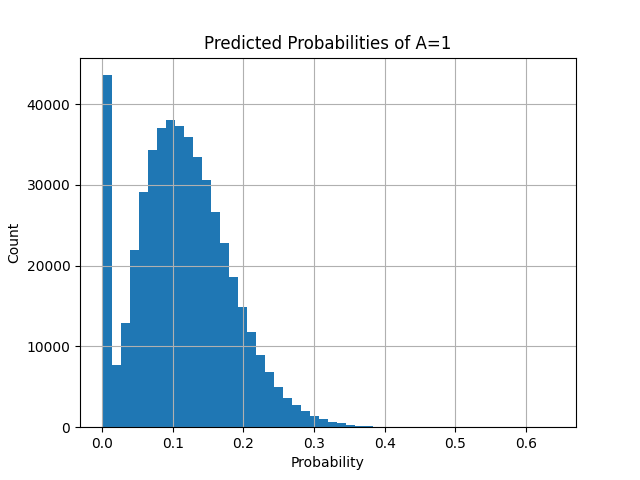

In [77]:
plt.hist(pred_probs, bins=50)
plt.title("Predicted Probabilities of A=1")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [78]:
from sklearn.metrics import classification_report, roc_auc_score

# Assume your true values are in `y_true` and predicted probs from `fit.predict()`
y_pred = (pred_probs > 0.2).astype(int)

print(classification_report(As, y_pred))
print("ROC AUC:", roc_auc_score(As, pred_probs))


ModuleNotFoundError: No module named 'sklearn'

In [ ]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(As, pred_probs)
print("Average Precision (PR AUC):", average_precision)


In [ ]:
NC = g.summary_dict['sim_data']['Natural course']

In [ ]:
# Compute LOS per admission
los_per_admission = NC.groupby('admission_id')['t0'].max() + 1  # +1 since t0 starts at 0

# Plot histogram
plt.figure(figsize=(8, 5))
los_per_admission.hist(bins=range(1, los_per_admission.max() + 2), edgecolor='black')
plt.xlabel("Length of Stay (number of time points)")
plt.ylabel("Number of Admissions")
plt.title("Distribution of Length of Stay")
plt.grid(True)
plt.tight_layout()
plt.savefig("los_NC.pdf")
plt.show()

In [ ]:
# Compute LOS (number of time points) per admission
los_per_admission = mimicdata.groupby('admission_id')['t0'].max() + 1  # +1 since t0 starts at 0

# Plot histogram
plt.figure(figsize=(8, 5))
los_per_admission.hist(bins=range(1, los_per_admission.max() + 2), edgecolor='black')
plt.xlabel("Length of Stay (number of time points)")
plt.ylabel("Number of Admissions")
plt.title("Distribution of Length of Stay")
plt.grid(True)
plt.tight_layout()
plt.savefig("los_mimic.pdf")
plt.show()

In [ ]:
DS = g.summary_dict['sim_data']['Discharge safe']
DR = g.summary_dict['sim_data']['Discharge risky']
DD = g.summary_dict['sim_data']['Discharge dangerous']

In [ ]:
DS

In [ ]:
# Compute LOS
los_ds = DS.groupby('admission_id')['t0'].max() + 1
los_dr = DR.groupby('admission_id')['t0'].max() + 1
los_dd = DD.groupby('admission_id')['t0'].max() + 1

# Create vertically stacked subplots
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)

# Plot for DS
axs[0].hist(los_ds, bins=range(1, 200), edgecolor='black', color='skyblue')
axs[0].set_title('LOS Distribution: DS')
axs[0].set_xlabel('Length of Stay (number of time points)')
axs[0].set_ylabel('Number of Admissions')
axs[0].grid(True)

# Plot for DR
axs[1].hist(los_dr, bins=range(1, 200), edgecolor='black', color='salmon')
axs[1].set_title('LOS Distribution: DR')
axs[1].set_xlabel('Length of Stay (number of time points)')
axs[1].set_ylabel('Number of Admissions')
axs[1].grid(True)

# Plot for DD
axs[2].hist(los_dd, bins=range(1, 200), edgecolor='black', color='salmon')
axs[2].set_title('LOS Distribution: DD')
axs[2].set_xlabel('Length of Stay (number of time points)')
axs[2].set_ylabel('Number of Admissions')
axs[2].grid(True)

# Final layout
plt.tight_layout()
plt.savefig("los_comp.pdf")
plt.show()


# Mean Y per LOS

In [ ]:
# Step 1: Get the last row for each admission (i.e., end of follow-up)
last_rows = mimicdata.sort_values("t0").groupby("admission_id").tail(1)

# Step 2: Calculate LOS for each admission
last_rows["los"] = mimicdata.groupby("admission_id")["t0"].nunique().values

# Step 3: Group by LOS and compute mean Y
mean_y_per_los = last_rows.groupby("los")["Y"].mean().reset_index()

# Step 4: Display
print(mean_y_per_los)


In [ ]:
mean_y_per_los.Y.mean()

In [ ]:
IPW = g.summary_dict['IP_weights']

In [ ]:
NC

# Distribution of GCS when A=1

In [ ]:
DI = g.summary_dict['sim_data']['Discharge extremely dangerous']

In [ ]:
DI

In [ ]:
# Filter data where A == 1
subset = DI[DI['A'] == 1]

# Plot distribution of X
plt.figure(figsize=(8, 5))
subset['glasgow_coma_scale_total__last__last_12h'].hist(bins=30, edgecolor='black')
plt.xlabel("L values (when A=1)")
plt.ylabel("Frequency")
plt.title("Distribution of X for A=1")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filter data where A == 1
subset = NC[NC['A'] == 1]

# Plot distribution of X
plt.figure(figsize=(8, 5))
subset['glasgow_coma_scale_total__last__last_12h'].hist(bins=30, edgecolor='black')
plt.xlabel("L values (when A=1)")
plt.ylabel("Frequency")
plt.title("Distribution of X for A=1")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
NC

In [ ]:
# Filter rows where A == 1
subset = DI[DI['A'] == 1]

# Loop through each variable in L
for var in picked_for_L:
    print(f"\n--- Variable: {var} ---")
    
    if pd.api.types.is_numeric_dtype(subset[var]):
        # For continuous variable: show min, max, mean
        print("Type: Continuous")
        print("Min:", subset[var].min())
        print("Max:", subset[var].max())
        print("Mean:", round(subset[var].mean(), 2))
    else:
        # For categorical variable: show value counts
        print("Type: Categorical")
        print(subset[var].value_counts(dropna=False))
